We will work with the StudentsPerfomance dataset and try to define corelation between different variables presented in the set

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
#Packages for random forest tree
import pickle as pkl
 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score



In [3]:
#Upload the dataset and set it as df0 
df0 = pd.read_csv("/Users/nazarcirkov/Downloads/StudentsPerformance.csv")
# Display info of the dataframe
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
# Display first few rows of the dataframe
df0.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39
8,male,group D,high school,free/reduced,completed,64,64,67
9,female,group B,high school,free/reduced,none,38,60,50


In [5]:
# Display the most usefull information(mean, std, count and so on) 
df0.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [6]:
# Change the naming to lower case
df0.columns = map(str.lower, df0.columns)
# Change not usuall name of race/ethnicity to just race
df0.rename(columns={df0.columns[1]: 'race'}, inplace=True)
# Change space to _
df0.columns = df0.columns.str.replace(' ', '_')
# Check how the info looks now
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race                         1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [7]:
# Dislpay the median of all 3 numerical columns
print(f"Math score median:{df0['math_score'].median()}")
print(f"Reading score median:{df0['reading_score'].median()}")
print(f"Writing score median:{df0['writing_score'].median()}")




Math score median:66.0
Reading score median:70.0
Writing score median:69.0


In [8]:
# Check for the scores less than 20 in each group
print((df0['math_score'] <= 20).value_counts())
print((df0['reading_score'] <= 20).value_counts())
print((df0['writing_score'] <= 20).value_counts())

math_score
False    996
True       4
Name: count, dtype: int64
reading_score
False    999
True       1
Name: count, dtype: int64
writing_score
False    997
True       3
Name: count, dtype: int64


#We need to create average score column because in future calculating we will use it

In [9]:
# Create a column which will contain the mean value of 3 numerical columns
df0['average_score'] = df0[['math_score', 'reading_score', 'writing_score']].mean(axis=1)
# Check the values in our new column
df0['average_score'].describe()

count    1000.000000
mean       67.770667
std        14.257326
min         9.000000
25%        58.333333
50%        68.333333
75%        77.666667
max       100.000000
Name: average_score, dtype: float64

In [10]:
# Check for Null values in the dataset
df0.isna().any(axis=1).sum()


0

In [11]:
# Print the number of duplicates in the dataset
print(df0.duplicated().value_counts())


False    1000
Name: count, dtype: int64


In [12]:
### We will perform our first point estimation test on this stage

# Create def to perform checking for several times
def calculator_ci(group_data, confidence_level=0.95):    

    # Step 1: Calculate sample mean and sample standard deviation
    sample_mean = np.mean(group_data)
    sample_std = np.std(group_data, ddof=1)  # Sample standard deviation (ddof=1 for sample)

    # Step 2: Calculate the standard error
    sample_size = len(group_data)
    standard_error = sample_std / np.sqrt(sample_size)

    # Step 3: Calculate the 95% confidence interval using the Z-distribution
    z_value = stats.norm.ppf(0.975)  # For 95% confidence, Z-value is 1.96
    margin_of_error = z_value * standard_error

    # Step 4: Compute the confidence interval
    confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)
    # Step 5: Return mean, lower and upper limits
    return sample_mean, confidence_interval[0], confidence_interval[1]

# Use our function to insert values of return into the new variables 
math_mean, math_ci_lower, math_ci_upper = calculator_ci(df0['math_score'])  
reading_mean, reading_ci_lower, reading_ci_upper = calculator_ci(df0['reading_score']) 
writing_mean, writing_ci_lower, writing_ci_upper = calculator_ci(df0['writing_score']) 


### I wanted to present this info to describe that we can be 95% cofident that our sample mean will be in range between as writen bellow 
print(f"Math Scores: Mean = {math_mean}, 95% CI = ({math_ci_lower}, {math_ci_upper})")
print(f"Reading Scores: Mean = {reading_mean}, 95% CI = ({reading_ci_lower}, {reading_ci_upper})")
print(f"Writing Scores: Mean = {writing_mean}, 95% CI = ({writing_ci_lower}, {writing_ci_upper})")





Math Scores: Mean = 66.089, 95% CI = (65.14919982820571, 67.02880017179429)
Reading Scores: Mean = 69.169, 95% CI = (68.26408735665979, 70.07391264334021)
Writing Scores: Mean = 68.054, 95% CI = (67.1121807272059, 68.99581927279411)


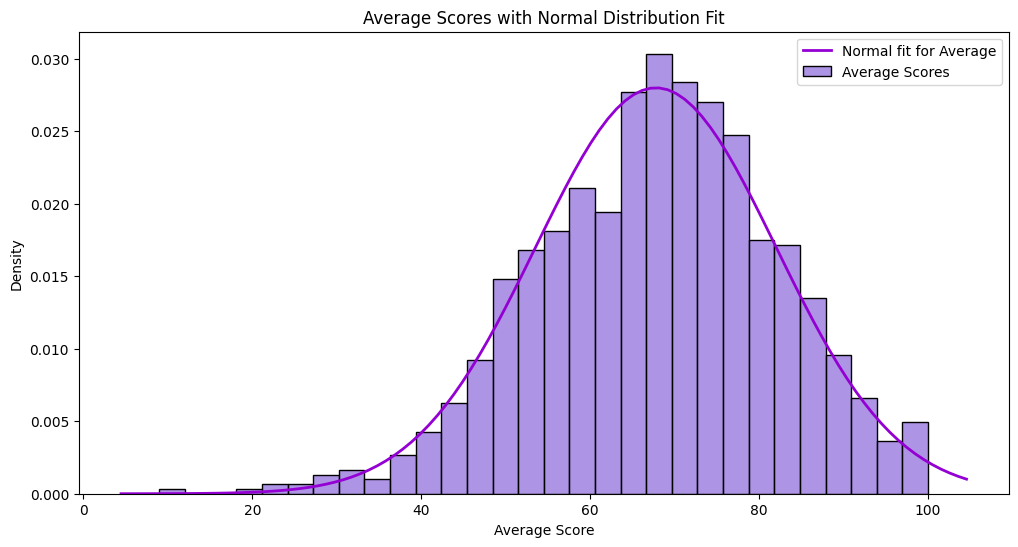

In [13]:
# Create "dataset" and insert in it only single column of df0 'average grade'
average_scores_for_visual = df0['average_score']

# Plotting Average Scores
plt.figure(figsize=(12, 6))

# Histogram for Average Scores
sns.histplot(average_scores_for_visual, kde=False, color='mediumpurple', stat='density', bins=30, label='Average Scores')

# Fit and plot a normal distribution curve for Average Scores
xmin, xmax = plt.xlim()  # Get the limits of the x-axis
x = np.linspace(xmin, xmax, 100)  # Generate 100 points from xmin to xmax
p_avg = norm.pdf(x, average_scores_for_visual.mean(), average_scores_for_visual.std())  # Normal distribution fit
plt.plot(x, p_avg, 'darkviolet', linewidth=2, label="Normal fit for Average")

# Title and labels
plt.title('Average Scores with Normal Distribution Fit')
plt.xlabel('Average Score')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show the plot
plt.show()


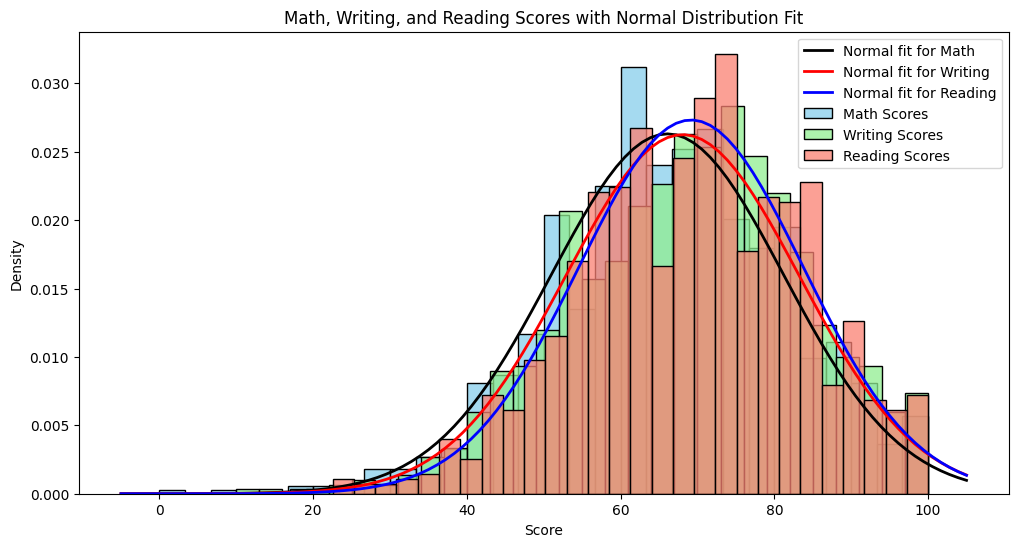

In [14]:
# Create three "dataset"s and insert in them only single column of df0 'score'
math_scores_for_visual = df0['math_score'] 
writing_scores_for_visual = df0['writing_score']
reading_scores_for_visual = df0['reading_score']

# Plotting Scores
plt.figure(figsize=(12, 6))

# Histogram for Math Scores
sns.histplot(math_scores_for_visual, kde=False, color='skyblue', stat='density', bins=30, label='Math Scores')
# Fit and plot a normal distribution curve for Math
xmin, xmax = plt.xlim()  # Get the limits of the x-axis
x = np.linspace(xmin, xmax, 100)
p_math = norm.pdf(x, math_scores_for_visual.mean(), math_scores_for_visual.std())
plt.plot(x, p_math, 'k', linewidth=2, label="Normal fit for Math")

# Histogram for Writing Scores
sns.histplot(writing_scores_for_visual, kde=False, color='lightgreen', stat='density', bins=30, label='Writing Scores')
# Fit and plot a normal distribution curve for Writing
p_writing = norm.pdf(x, writing_scores_for_visual.mean(), writing_scores_for_visual.std())
plt.plot(x, p_writing, 'r', linewidth=2, label="Normal fit for Writing")

# Histogram for Reading Scores
sns.histplot(reading_scores_for_visual, kde=False, color='salmon', stat='density', bins=30, label='Reading Scores')
# Fit and plot a normal distribution curve for Reading
p_reading = norm.pdf(x, reading_scores_for_visual.mean(), reading_scores_for_visual.std())
plt.plot(x, p_reading, 'b', linewidth=2, label="Normal fit for Reading")

# Title and labels
plt.title('Math, Writing, and Reading Scores with Normal Distribution Fit')
plt.xlabel('Score')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show the plot
plt.show()


<Axes: ylabel='average_score'>

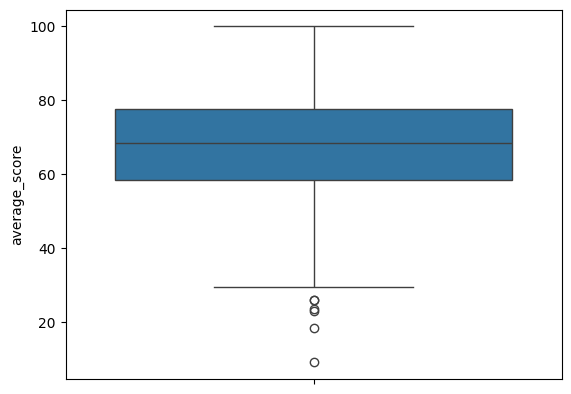

In [15]:
# Create box plot for average score data distribution
sns.boxplot(data=df0,y = 'average_score')


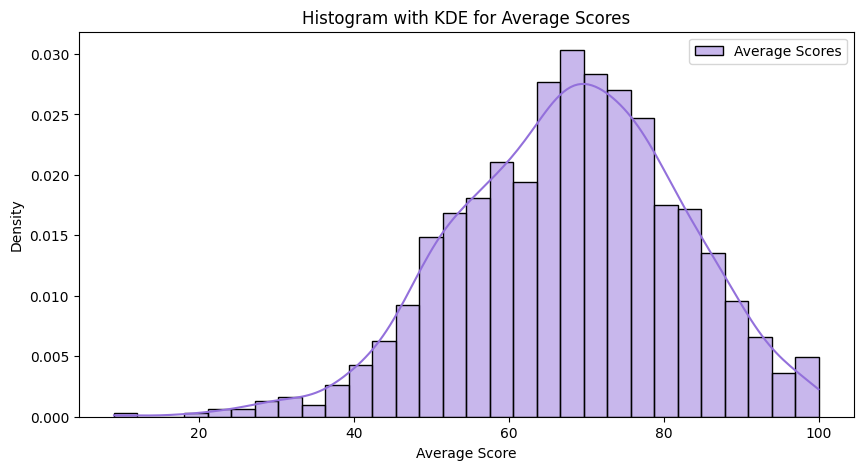

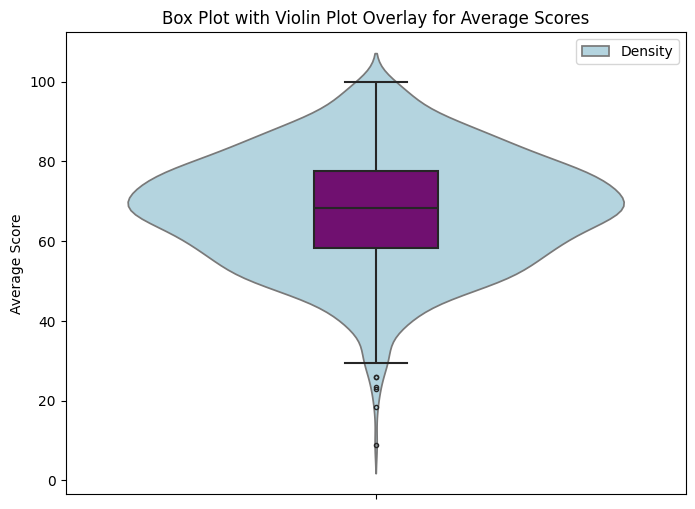

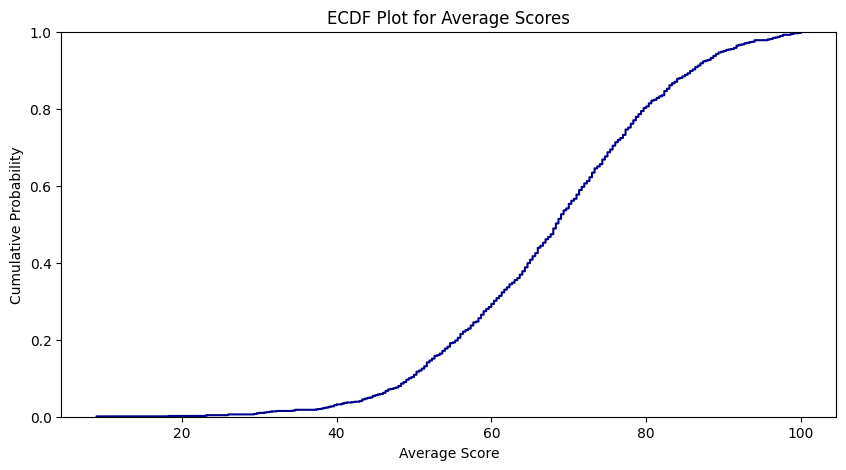

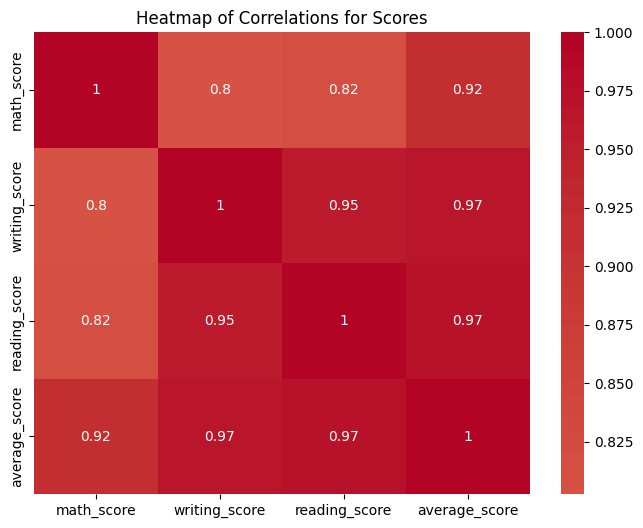

In [16]:
# Assuming df0['average_score'] is already calculated
average_scores = df0['average_score']

# 1. Histogram with KDE for Average Scores
plt.figure(figsize=(10, 5))
sns.histplot(average_scores, kde=True, color='mediumpurple', stat='density', bins=30, label='Average Scores')
plt.title('Histogram with KDE for Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 2. Box Plot with Violin Plot Overlay
plt.figure(figsize=(8, 6))
sns.violinplot(y=average_scores, color='lightblue', inner=None, label='Density')
sns.boxplot(y=average_scores, color='purple', width=0.2, fliersize=3, linewidth=1.5)
plt.title('Box Plot with Violin Plot Overlay for Average Scores')
plt.ylabel('Average Score')
plt.legend()
plt.show()

# 3. ECDF Plot for Average Scores
plt.figure(figsize=(10, 5))
sns.ecdfplot(average_scores, color='darkblue')
plt.title('ECDF Plot for Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Cumulative Probability')
plt.show()

# 4. Heatmap of Correlations
plt.figure(figsize=(8, 6))
correlation_data = df0[['math_score', 'writing_score', 'reading_score', 'average_score']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlations for Scores')
plt.show()


In [17]:
df0.head()

,gender,race,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,average_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [18]:
#On this stage we will test two hypothesis for the first time and here it's about dependens of gender and average score
data = df0.copy()

# Separate the data by gender
male_scores = data[data['gender'] == 'male']['average_score']
female_scores = data[data['gender'] == 'female']['average_score']

# Perform an independent t-test to compare the average scores of male and female students
t_statistic, p_value = stats.ttest_ind(male_scores, female_scores)


print("Hypothesis Testing for Dependence of Gender and Average Score")
print("Null Hypothesis (H0): There is no significant difference in the average scores between male and female students.")
print("Alternative Hypothesis (H1): There is a significant difference in the average scores between male and female students.")


# Output the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")


# Interpretation
alpha = 0.05  # 5% significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the average scores between male and female students.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the average scores between male and female students.")


Hypothesis Testing for Dependence of Gender and Average Score
Null Hypothesis (H0): There is no significant difference in the average scores between male and female students.
Alternative Hypothesis (H1): There is a significant difference in the average scores between male and female students.
T-statistic: -4.169913529142
P-value: 3.311973638243664e-05
Reject the null hypothesis: There is a significant difference in the average scores between male and female students.


In [20]:
#Here we will test our second hypothesis for independance of compleating preparation course and average grade
data = df0.copy()

# Separate the data by gender
complete_score = data[data['test_preparation_course'] == 'completed']['average_score']
none_score = data[data['test_preparation_course'] == 'none']['average_score']

# Perform an independent t-test to compare the average scores of those who completed preparation course others who have not
t_statistic, p_value = stats.ttest_ind(complete_score, none_score)

print("Null Hypothesis (H0): There is no significant difference in the average scores between those who completed preparation course and those who have not.")
print("Alternative Hypothesis (H1): There is significant difference in the average scores between those who completed preparation course and those who have not.")


# Output the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # 5% significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the average scores between those who completed preparation course and those who have not.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the average scores between those who completed preparation course and those who have not.")

Null Hypothesis (H0): There is no significant difference in the average scores between those who completed preparation course and those who have not.
Alternative Hypothesis (H1): There is significant difference in the average scores between those who completed preparation course and those who have not.
T-statistic: 8.390944443482592
P-value: 1.633780203592351e-16
Reject the null hypothesis: There is a significant difference in the average scores between those who completed preparation course and those who have not.


/var/folders/zt/0kvp2g3d005_wgdv2qkpznw40000gn/T/ipykernel_99171/3604426994.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(complete_score, color='blue', label='Completed Preparation Course', shade=True)
/var/folders/zt/0kvp2g3d005_wgdv2qkpznw40000gn/T/ipykernel_99171/3604426994.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(none_score, color='orange', label='Did Not Complete Preparation Course', shade=True)


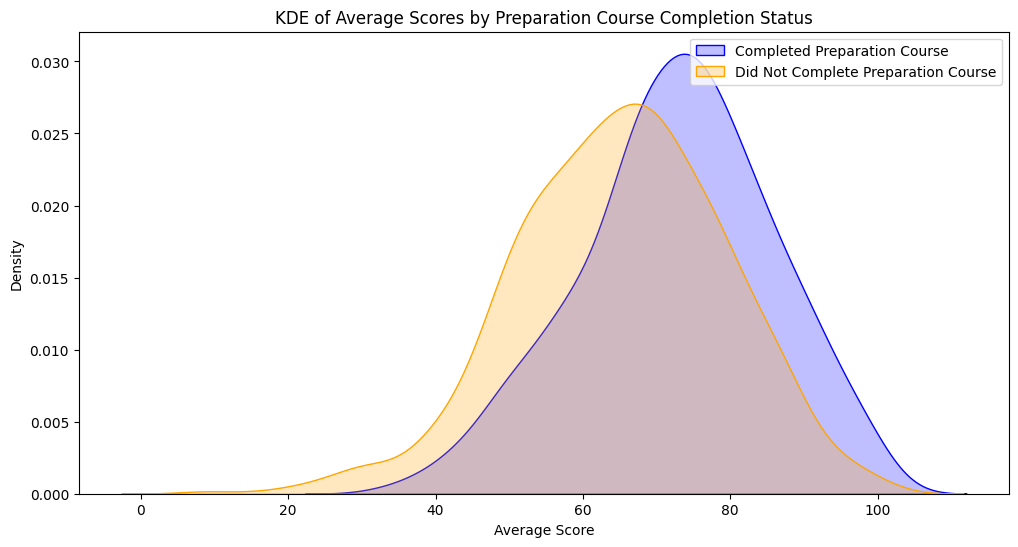

In [21]:
# Set a data to value of df0
data = df0.copy()

# Visualize the distribution of average scores with KDE for both groups
plt.figure(figsize=(12, 6))

# KDE Plot for those who completed the course
sns.kdeplot(complete_score, color='blue', label='Completed Preparation Course', shade=True)

# KDE Plot for those who did not complete the course
sns.kdeplot(none_score, color='orange', label='Did Not Complete Preparation Course', shade=True)

# Title and labels
plt.title("KDE of Average Scores by Preparation Course Completion Status")
plt.xlabel("Average Score")
plt.ylabel("Density")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [22]:
#Another way to check independance of two groups
# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(complete_score, none_score, alternative='two-sided')

print("Null Hypothesis (H0): There is no significant difference in the average scores between those who completed preparation course and those who have not.")
print("Alternative Hypothesis (H1): There is significant difference in the average scores between those who completed preparation course and those who have not.")



# Output the results
print(f"U-statistic: {u_statistic}")
print(f"P-value: {p_value}")



# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the average scores between those who completed the preparation course and those who have not.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the average scores between those who completed the preparation course and those who have not.")


Null Hypothesis (H0): There is no significant difference in the average scores between those who completed preparation course and those who have not.
Alternative Hypothesis (H1): There is significant difference in the average scores between those who completed preparation course and those who have not.
U-statistic: 150319.5
P-value: 6.202995039227688e-16
Reject the null hypothesis: There is a significant difference in the average scores between those who completed the preparation course and those who have not.


In [23]:
# On this stage I Performed ANOVA test to check whether it's difference in means in our race groups
data = df0.copy()
group_A = data[data['race'] == 'group A']['average_score']
group_B = data[data['race'] == 'group B']['average_score']
group_C = data[data['race'] == 'group C']['average_score']
# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(group_A, group_B, group_C)

print("Null Hypothesis (H0): The means of the groups are not significantly different.")
print("Alternative Hypothesis (H1): At least one group has a significantly different mean.")

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Decision
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: At least one group has a significantly different mean.")
else:
    print("Fail to reject the null hypothesis: The means of the groups are not significantly different.")


Null Hypothesis (H0): The means of the groups are not significantly different.
Alternative Hypothesis (H1): At least one group has a significantly different mean.
F-statistic: 3.1264097221860623
P-value: 0.04459666103454518
Reject the null hypothesis: At least one group has a significantly different mean.


In [24]:
# Step 1: Set up the threshold for the average grade to be considered as High
threshold = 64
# Step 2: Create a new dataset with high scores only and set to boolian numerical data type
df0['high_score'] = df0['average_score'].apply(lambda x: 'High' if x >= threshold else 'Not')

# Step 3: Create a contingency table for parental education and high score status
contingency_table = pd.crosstab(df0['parental_level_of_education'], df0['high_score'])

# Display the contingency table
print("Contingency Table:")
print(contingency_table)

# Step 4: Perform the Chi-Square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Display results
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(expected)

# Step 5: Interpret the results based on p-value
alpha = 0.05  # Significance level
if p_value < alpha:
    print("\nConclusion: Reject the null hypothesis. There is a significant association between parental education level and high average score.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. There is no significant association between parental education level and high average score.")


Contingency Table:
high_score                   High  Not
parental_level_of_education           
associate's degree            149   73
bachelor's degree              89   29
high school                   104   92
master's degree                43   16
some college                  142   84
some high school              104   75

Chi-Square Test Results:
Chi-Square Statistic: 22.071472616044584
P-value: 0.0005074682013244156
Degrees of Freedom: 5
Expected Frequencies Table:
[[140.082  81.918]
 [ 74.458  43.542]
 [123.676  72.324]
 [ 37.229  21.771]
 [142.606  83.394]
 [112.949  66.051]]

Conclusion: Reject the null hypothesis. There is a significant association between parental education level and high average score.


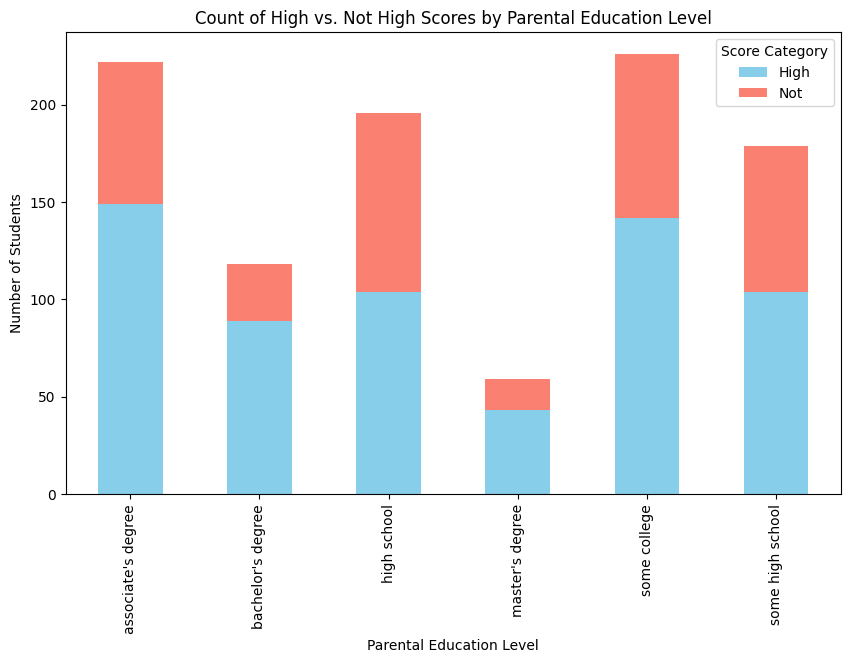

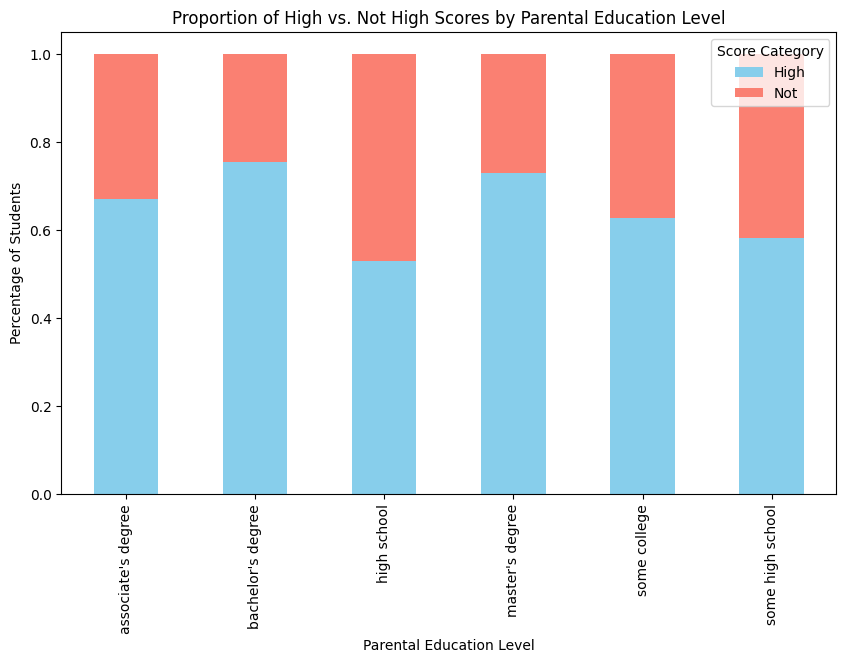

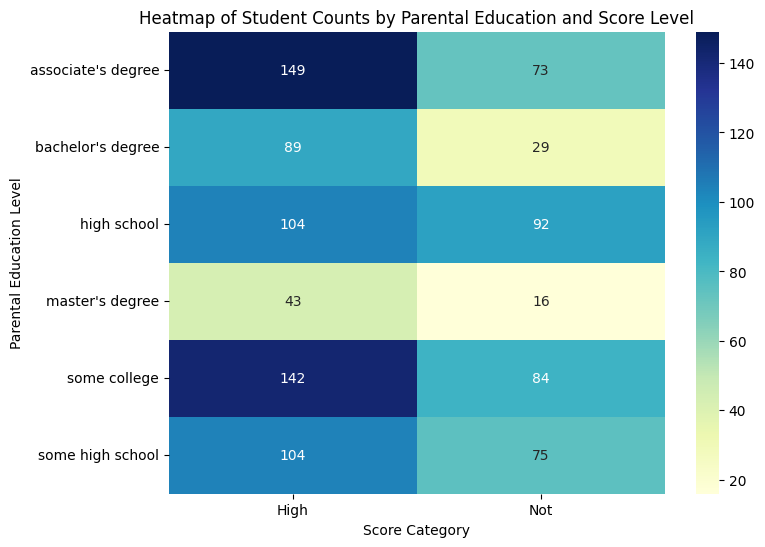

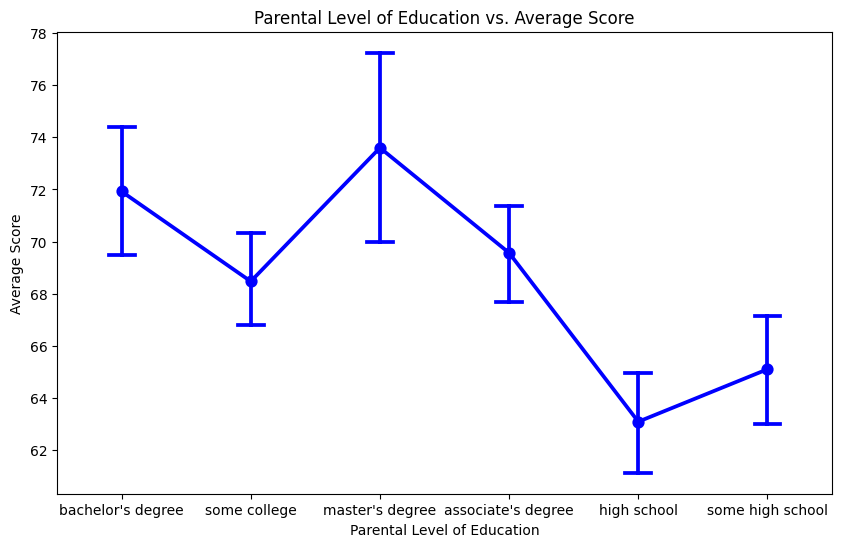

In [40]:
# Make visualisation for our recently created data columns
# Step 1: Create contingency table for visualization
contingency_table_ploe_hs = pd.crosstab(df0['parental_level_of_education'], df0['high_score'])

# Step 2: Plotting

# 1. Stacked Bar Plot
contingency_table_ploe_hs.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], figsize=(10, 6))
plt.title('Count of High vs. Not High Scores by Parental Education Level')
plt.xlabel('Parental Education Level')
plt.ylabel('Number of Students')
plt.legend(title='Score Category')
plt.show()

# 2. Percentage Stacked Bar Plot
# Normalize data for percentage representation
contingency_percent = contingency_table_ploe_hs.div(contingency_table_ploe_hs.sum(axis=1), axis=0)
contingency_percent.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], figsize=(10, 6))
plt.title('Proportion of High vs. Not High Scores by Parental Education Level')
plt.xlabel('Parental Education Level')
plt.ylabel('Percentage of Students')
plt.legend(title='Score Category')
plt.show()

# 3. Heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title('Heatmap of Student Counts by Parental Education and Score Level')
plt.xlabel('Score Category')
plt.ylabel('Parental Education Level')
plt.show()
# Plotting the regression line
plt.figure(figsize=(10, 6))
sns.pointplot(x='parental_level_of_education', y='average_score', data=df0, color="blue", capsize=.2)
plt.title('Parental Level of Education vs. Average Score')
plt.xlabel('Parental Level of Education')
plt.ylabel('Average Score')
plt.show()



In [41]:
import statsmodels.api as sm
# Define independent (X) and dependent (Y) variables
X_for_regr = df0['math_score']
Y_for_regr = df0['reading_score']

# Add a constant to the model (for the intercept term)
X_for_regr = sm.add_constant(X_for_regr)

# Fit the regression model
model = sm.OLS(Y_for_regr, X_for_regr).fit()
# Show summary info about the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          reading_score   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2012.
Date:                Thu, 14 Nov 2024   Prob (F-statistic):          1.79e-241
Time:                        11:43:09   Log-Likelihood:                -3547.5
No. Observations:                1000   AIC:                             7099.
Df Residuals:                     998   BIC:                             7109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1418      1.190     14.405      0.0

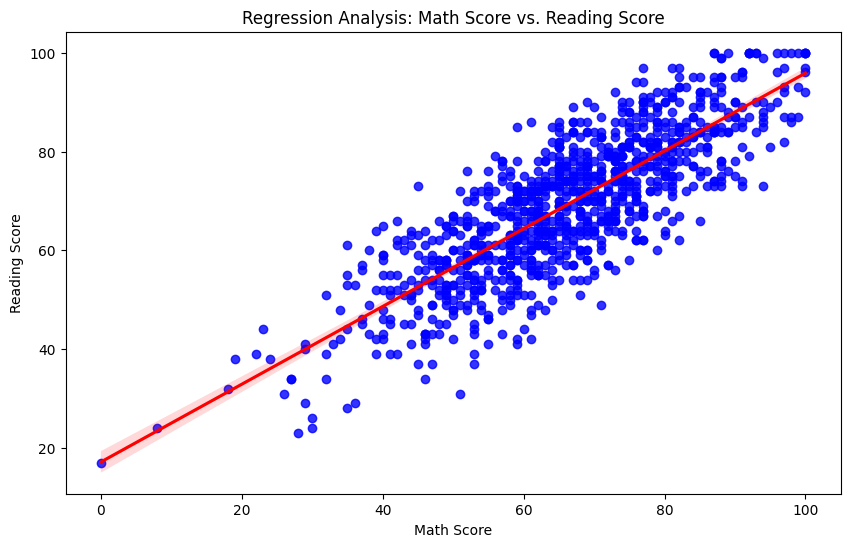

In [42]:
# Plotting the regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='math_score', y='reading_score', data=df0, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Regression Analysis: Math Score vs. Reading Score')
plt.xlabel('Math Score')
plt.ylabel('Reading Score')
plt.show()


In [43]:
# Hypothesis testing
n = df0['gender'].count()  # total number of male students in the sample (for example)
p0 = 0.20  # hypothesized proportion (20%)

# Calculate the actual proportion of male students with high average scores
high_score_male = df0[(df0['gender'] == 'male') & (df0['high_score'] == 'High')].shape[0]
phat = high_score_male / n  # sample proportion

# Z-test statistic calculation
z = (phat - p0) / np.sqrt((p0 * (1 - p0)) / n)

# Significance level
alpha = 0.05
critical_value = norm.ppf(1 - alpha)  # one-tailed test

# P-value for the observed z-score
p_value = 1 - norm.cdf(z)

# Output results
print(f"Sample proportion: {phat:.4f}")
print(f"Z-test statistic: {z:.4f}")
print(f"Critical value (for alpha={alpha}): {critical_value:.4f}")
print(f"P-value: {p_value:.4f}")

# Conclusion
if z > critical_value:
    print("Reject the null hypothesis: More than 20% of male students have a high average score.")
else:
    print("Fail to reject the null hypothesis: Not enough evidence to conclude more than 20% of male students have a high average score.")


Sample proportion: 0.2760
Z-test statistic: 6.0083
Critical value (for alpha=0.05): 1.6449
P-value: 0.0000
Reject the null hypothesis: More than 20% of male students have a high average score.


In [46]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table_g_hs = pd.crosstab(df0['gender'], df0['high_score'])
# Print our contingency table
print(contingency_table_g_hs)
# Perform Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_g_hs)
# Print the results of our chi squere test
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
# Decision
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant association between gender and having a high average score.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between gender and having a high average score.")


high_score  High  Not
gender               
female       355  163
male         276  206
Chi-Square Statistic: 13.1433599511973
P-value: 0.0002885399671997824
Reject the null hypothesis: There is a significant association between gender and having a high average score.


In [75]:
# Prepare binary variable for high average score
df0['high_score_binary'] = df0.pop('high_score').apply(lambda x: 1 if x == 'High' else 0)


In [76]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#Set a df1 to a copy of df0
df1 = df0.copy()
# Logistic regression model
model = smf.logit('high_score_binary ~ gender + race + parental_level_of_education + lunch + test_preparation_course', data=df1).fit()
#Print result of the logit regression
print(model.summary())



Optimization terminated successfully.
         Current function value: 0.562474
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      high_score_binary   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      987
Method:                           MLE   Df Model:                           12
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                  0.1457
Time:                        12:11:42   Log-Likelihood:                -562.47
converged:                       True   LL-Null:                       -658.42
Covariance Type:            nonrobust   LLR p-value:                 1.529e-34
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                       

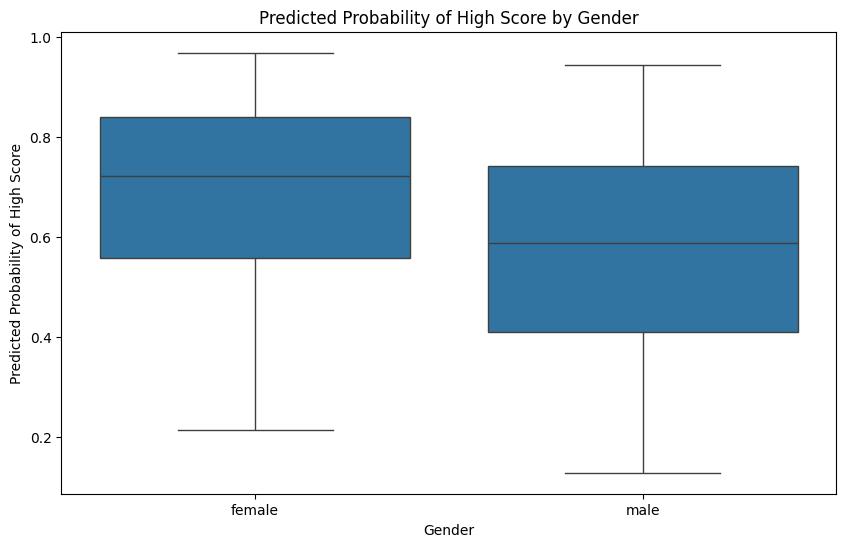

In [77]:
# Predict probabilities for each observation in the dataset
df1['predicted_prob'] = model.predict(df1)

# Visualize the predicted probabilities
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='predicted_prob', data=df1)
plt.title('Predicted Probability of High Score by Gender')
plt.ylabel('Predicted Probability of High Score')
plt.xlabel('Gender')
plt.show()


In [78]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict probabilities and convert to binary predictions (using threshold of 0.5)
df1['predicted'] = (model.predict(df1) >= 0.5).astype(int)

# Confusion matrix and metrics
cm = confusion_matrix(df1['high_score_binary'], df1['predicted'])
accuracy = accuracy_score(df1['high_score_binary'], df1['predicted'])
precision = precision_score(df1['high_score_binary'], df1['predicted'])
recall = recall_score(df1['high_score_binary'], df1['predicted'])
f1 = f1_score(df1['high_score_binary'], df1['predicted'])
# Print result
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.71
Precision: 0.73
Recall: 0.84
F1 Score: 0.78


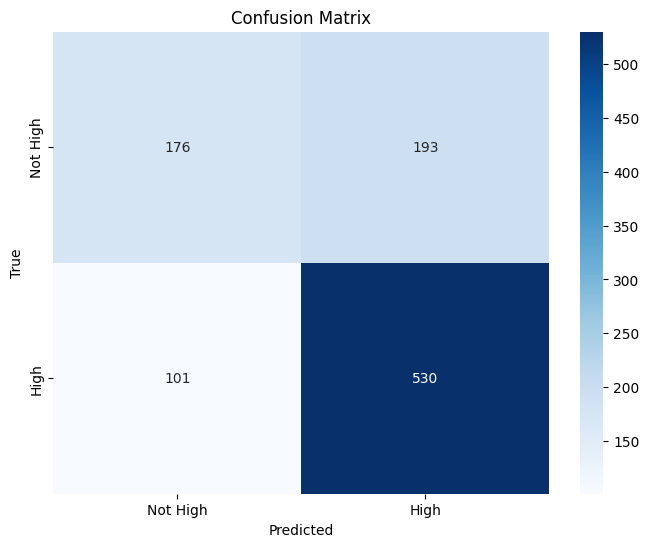

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the class labels (0 or 1) from the model
y_true = df1['high_score_binary']
y_pred = model.predict(df1) > 0.5  # Use a threshold of 0.5 works to determine whether prediction was succesfull >0.5 or failuer < 0.5

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not High', 'High'], yticklabels=['Not High', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [80]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   race                         1000 non-null   object 
 2   parental_level_of_education  1000 non-null   object 
 3   lunch                        1000 non-null   object 
 4   test_preparation_course      1000 non-null   object 
 5   math_score                   1000 non-null   int64  
 6   reading_score                1000 non-null   int64  
 7   writing_score                1000 non-null   int64  
 8   average_score                1000 non-null   float64
 9   high_score_binary            1000 non-null   int64  
 10  predicted                    1000 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 86.1+ KB


In [81]:
df0.head(5)

,gender,race,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,average_score,high_score_binary,predicted
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,1,1
1,female,group C,some college,standard,completed,69,90,88,82.333333,1,1
2,female,group B,master's degree,standard,none,90,95,93,92.666667,1,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,0,0
4,male,group C,some college,standard,none,76,78,75,76.333333,1,1


#IN thsi part I will perform more advance statistics to define the best model which will predict high grade based on different factors exept of actual grade such as it has obious strong corelation with high or not high grade

In [82]:
# Create a new data set and set to it df0 with the exceptions that all of cotegorial columns will be transformeded to the dummies
df_dummies = pd.get_dummies(df0)
# Set to the boolean_columns our previously converted columns to bool datatype
boolean_columns = df_dummies.select_dtypes(include='bool').columns
# Convert only the boolean columns to integers (0 and 1)
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)

In [83]:
# Check whether all columns are in proper datatype
df_dummies.head()

,math_score,reading_score,writing_score,average_score,high_score_binary,predicted,gender_female,gender_male,race_group A,race_group B,...,parental_level_of_education_associate's degree,parental_level_of_education_bachelor's degree,parental_level_of_education_high school,parental_level_of_education_master's degree,parental_level_of_education_some college,parental_level_of_education_some high school,lunch_free/reduced,lunch_standard,test_preparation_course_completed,test_preparation_course_none
0,72,72,74,72.666667,1,1,1,0,0,1,...,0,1,0,0,0,0,0,1,0,1
1,69,90,88,82.333333,1,1,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,90,95,93,92.666667,1,1,1,0,0,1,...,0,0,0,1,0,0,0,1,0,1
3,47,57,44,49.333333,0,0,0,1,1,0,...,1,0,0,0,0,0,1,0,0,1
4,76,78,75,76.333333,1,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1


In [84]:
import plotly.io as pio
pio.renderers.default = 'browser'

import plotly.express as px
# Present correlation map to make sure that we will not but highly related values to high_score_binary
fig = px.imshow(df_dummies.corr())
fig.show()

In [90]:
# Set to our depandent variable y values of high_score_binary data columns
y = df_dummies['high_score_binary']
# Set rest of the columns to X exept of the columns with high corr level
X = df_dummies.drop(['high_score_binary', 'math_score','reading_score', 'average_score','writing_score','predicted'], axis=1)

In [87]:
#Check whether y has the right values
y.head()

0    1
1    1
2    1
3    0
4    1
Name: high_score_binary, dtype: int64

In [91]:
#check whether X has right values
X.head()


,gender_female,gender_male,race_group A,race_group B,race_group C,race_group D,race_group E,parental_level_of_education_associate's degree,parental_level_of_education_bachelor's degree,parental_level_of_education_high school,parental_level_of_education_master's degree,parental_level_of_education_some college,parental_level_of_education_some high school,lunch_free/reduced,lunch_standard,test_preparation_course_completed,test_preparation_course_none
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
2,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1


In [94]:
#Set the timer in the moment when we start our model and till the moment model will finish to keep tracking that
%%time
# Use train_test_split function to devide existed data into separate group with ranom sampling method and sample size of 70% for train and 30% for test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
# set to clf_log result of our model
clf_log = LogisticRegression(solver='liblinear').fit(X_train,y_train)
clf_log.coef_

UsageError: Line magic function `%%time` not found.


In [96]:
# Set the value of y_pred_log to the prediction of our models based on the X_test
y_pred_log = clf_log.predict(X_test)
# Set the matrix to display PT, PF, NT, NF
cm = metrics.confusion_matrix(y_test, y_pred_log, labels = clf_log.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf_log.classes_)
# Display our plot
disp.plot()


NameError: name 'clf_log' is not defined

In [230]:

#Set an empty table
table = pd.DataFrame()

    # Create table of results
table = pd.DataFrame({'Model': 'LogisticRegression',
                          'F1': metrics.f1_score(y_test, y_pred_log),
                          'Recall': metrics.recall_score(y_test, y_pred_log),
                          'Precision': metrics.precision_score(y_test, y_pred_log),
                          'Accuracy': metrics.accuracy_score(y_test, y_pred_log)
                    }, index=[0]
                    )


In [231]:
# Presetn our table and check for the main characteristics of it
table

,Model,F1,Recall,Precision,Accuracy
0,LogisticRegression,0.744304,0.812155,0.686916,0.663333


In [232]:
%%time

# Use previosly seted X and y for this model as well
#Set a value of decision_tree to DecisionTreeClassifier model
decision_tree = DecisionTreeClassifier(random_state=0)
#Fit our model with X_train and y_train
decision_tree.fit(X_train, y_train)
#Set dt_pred value of our prediction based on X_test
dt_pred = decision_tree.predict(X_test)
#Present the results of our Decision Tree
print("Decision Tree")
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, dt_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, dt_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_test, dt_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, dt_pred))

Decision Tree
Accuracy: 0.610000
Precision: 0.672043
Recall: 0.690608
F1 Score: 0.681199
CPU times: user 7.99 ms, sys: 1.55 ms, total: 9.54 ms
Wall time: 8.49 ms


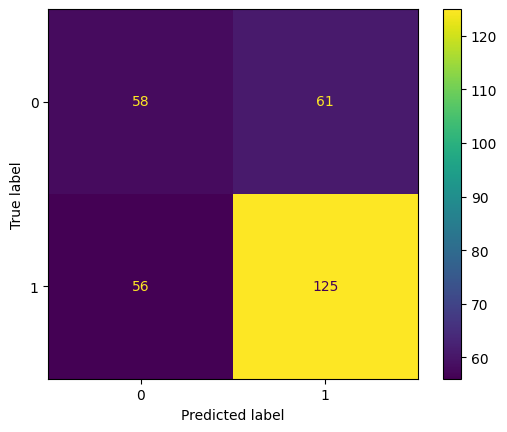

In [233]:
# Set to cm values of of y_test and dt_pred
cm = metrics.confusion_matrix(y_test, dt_pred, labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)
disp.plot()

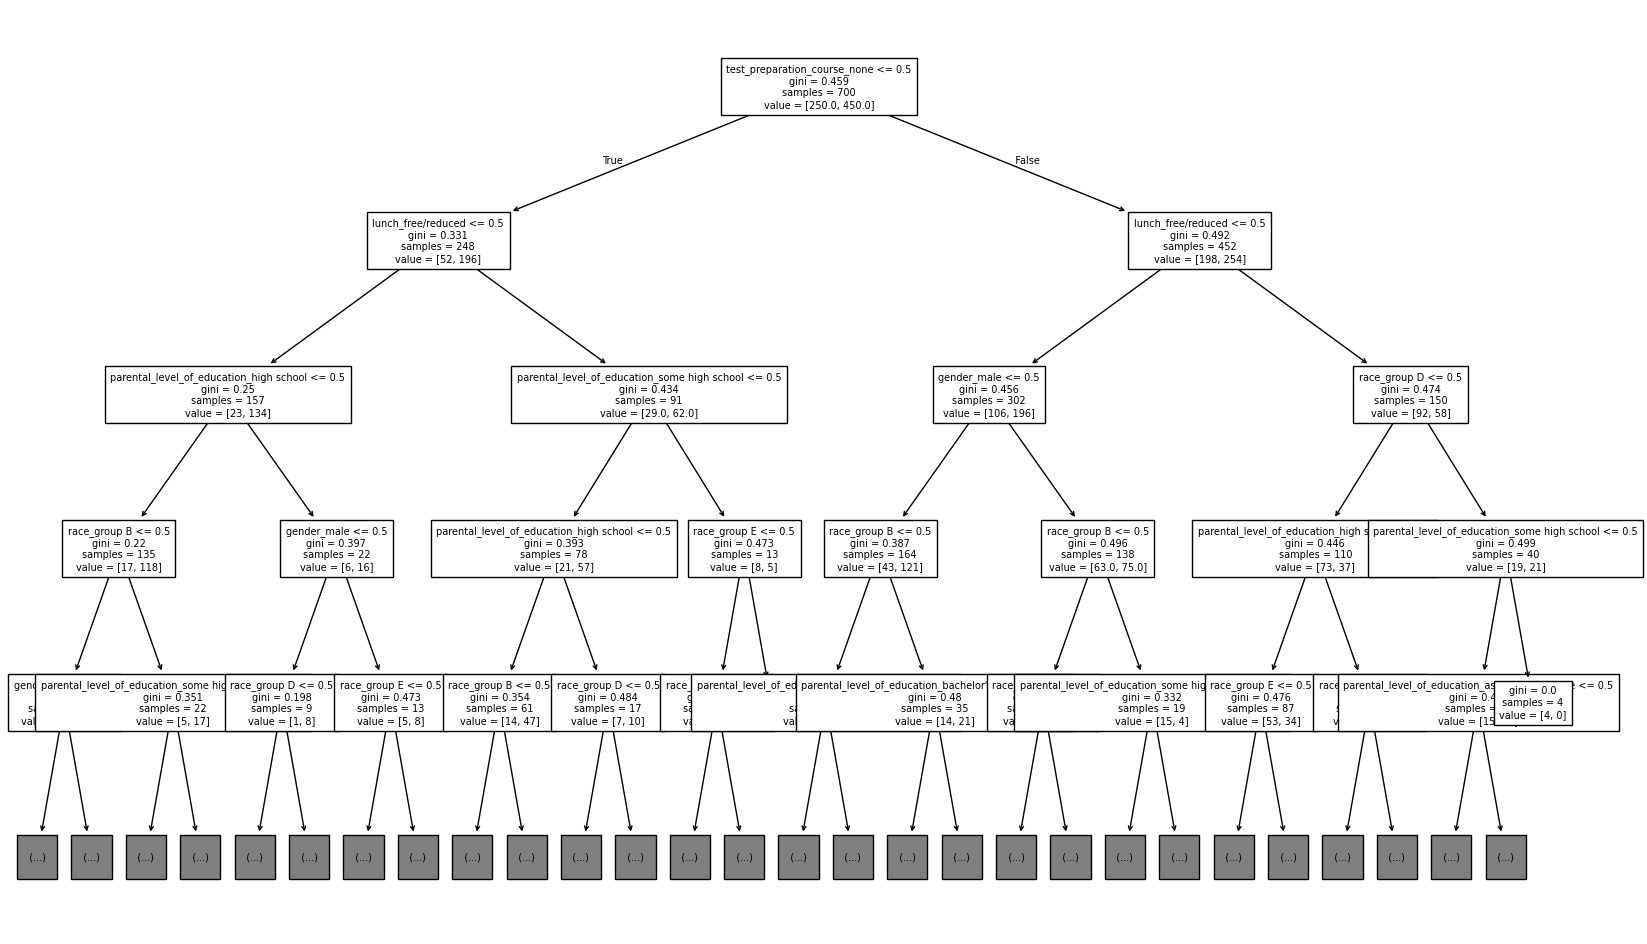

In [234]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,12))
plot_tree(decision_tree, max_depth=4, fontsize=7, feature_names=X.columns);

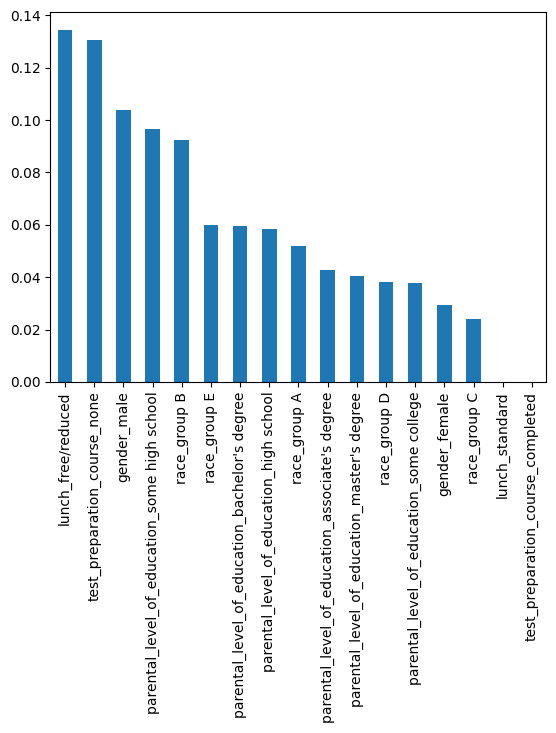

In [235]:
importances = decision_tree.feature_importances_

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

In [236]:
%%time
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=0)

# Define the parameter grid for GridSearchCV
cv_params = {'max_depth': [2, 3, 4, 5, None], 
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4],
             'max_features': [2, 3, 4],
             'n_estimators': [75, 100, 125, 150]}

# Define the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Set up the GridSearchCV with multiple scoring metrics and refit on the 'f1' score
rf_cv = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=5, refit='f1')

# Fit the model with cross-validation
rf_cv.fit(X_train, y_train)

# Get the best parameters and the best score based on 'f1'
print(f"Best parameters: {rf_cv.best_params_}")
print(f"Best F1 score: {rf_cv.best_score_}")


Best parameters: {'max_depth': 2, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
Best F1 score: 0.7896455362515205
CPU times: user 3min 59s, sys: 1.11 s, total: 4min
Wall time: 4min 3s


In [238]:
# Model for fitting results into table
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [239]:
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results.head()

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.789646,0.913281,0.695938,0.693333


In [240]:
rf_opt = RandomForestClassifier(n_estimators = 75, max_depth = 2, 
                                min_samples_leaf = 2, min_samples_split = 2,
                                max_features=4, random_state = 0)

In [241]:
%%time

rf_opt.fit(X_train, y_train)


CPU times: user 55.7 ms, sys: 1.84 ms, total: 57.6 ms
Wall time: 56.6 ms


RandomForestClassifier(max_depth=2, max_features=4, min_samples_leaf=2,
                       n_estimators=75, random_state=0)

In [285]:
X_test.head()


,gender_female,gender_male,race_group A,race_group B,race_group C,race_group D,race_group E,parental_level_of_education_associate's degree,parental_level_of_education_bachelor's degree,parental_level_of_education_high school,parental_level_of_education_master's degree,parental_level_of_education_some college,parental_level_of_education_some high school,lunch_free/reduced,lunch_standard,test_preparation_course_completed,test_preparation_course_none
521,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1
737,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
740,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1
660,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
411,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0


In [282]:
y_pred_tuned_random_forest = rf_opt.predict(X_test)


In [283]:
pc_test = precision_score(y_test, y_pred_tuned_random_forest, pos_label = 1)
print("The precision score is {pc:.3f}".format(pc = pc_test))
rc_test = recall_score(y_test, y_pred_tuned_random_forest, pos_label = 1)
print("The recall score is {rc:.3f}".format(rc = rc_test))
ac_test = accuracy_score(y_test, y_pred_tuned_random_forest)
print("The accuracy score is {ac:.3f}".format(ac = ac_test))
f1_test = f1_score(y_test, y_pred_tuned_random_forest, pos_label = 1)
print("The F1 score is {f1:.3f}".format(f1 = f1_test))

table2 = pd.DataFrame({'Model': ["Tuned Random Forest"],
                        'F1':  [f1_test],
                        'Recall': [rc_test],
                        'Precision': [pc_test],
                        'Accuracy': [ac_test]
                      }
                    )


table2


The precision score is 0.660
The recall score is 0.861
The accuracy score is 0.645
The F1 score is 0.747


,Model,F1,Recall,Precision,Accuracy
0,Tuned Random Forest,0.747331,0.860656,0.660377,0.645


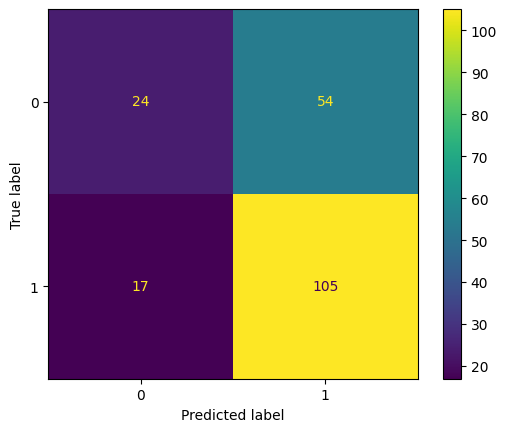

In [284]:
cm = metrics.confusion_matrix(y_test, y_pred_tuned_random_forest, labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)
disp.plot()